# 1. Introduction

Airbnb is an online marketplace for arranging or offering lodging, primarily homestays, or tourism experiences since 2008. NYC is the most populous city in the United States and also one of the most popular tourism and business place in the world. 

Airbnb NYC 2019 data contains listing activity and metrics. In this repository, I would like to choose the best prediction model for price. Meanwhile, price feature's relationship examines with others and some data exploratory analysis will be made. 

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

First, data content will be examined. 

In [48]:
nyc_data = pd.read_csv('data/AB_NYC_2019.csv')

In [49]:
nyc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

In [50]:
nyc_data.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [51]:
nyc_data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Above table shows that, there are some missing data for some features. They will be detailed later. 

# 2. Data Exploratory Analysis

The first graph is about the relationship between ``price`` and ``room type``. The ``Shared room`` price is always lower than 2000 dollars. On the other hand, the ``private room`` and the ``entire home`` have the highest price in some. 

Text(0.5, 1.0, 'Room Type vs Price')

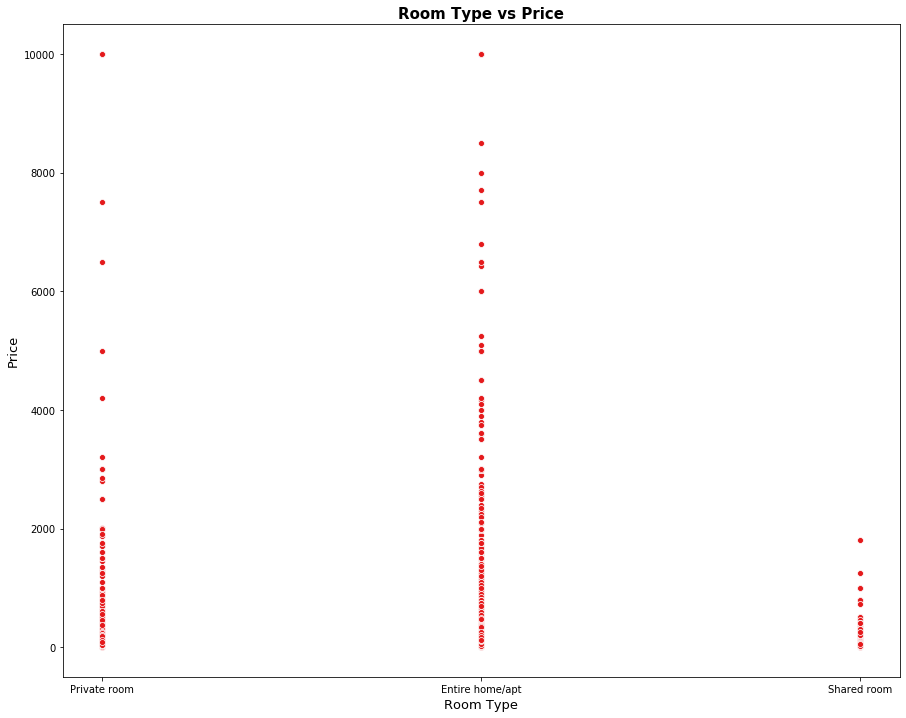

In [52]:
plt.figure(figsize=(15,12))
sns.scatterplot(x='room_type', y='price', data=nyc_data)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price",size=15, weight='bold')

Below graph shows details about ``price`` and ``room type`` based on ``neighborhood group``. The highest price of ``Private Room`` and ``Entire Home/Apt``is in the same area which is ``Manhattan``. Also, Brooklyn has very-high prices both in ``Private Room`` and ``Entire Home/Apt``. On the other hand,  ``shared room``'s highest price is in the Queens area.

Text(0.5, 1.0, 'Room Type vs Price vs Neighbourhood Group')

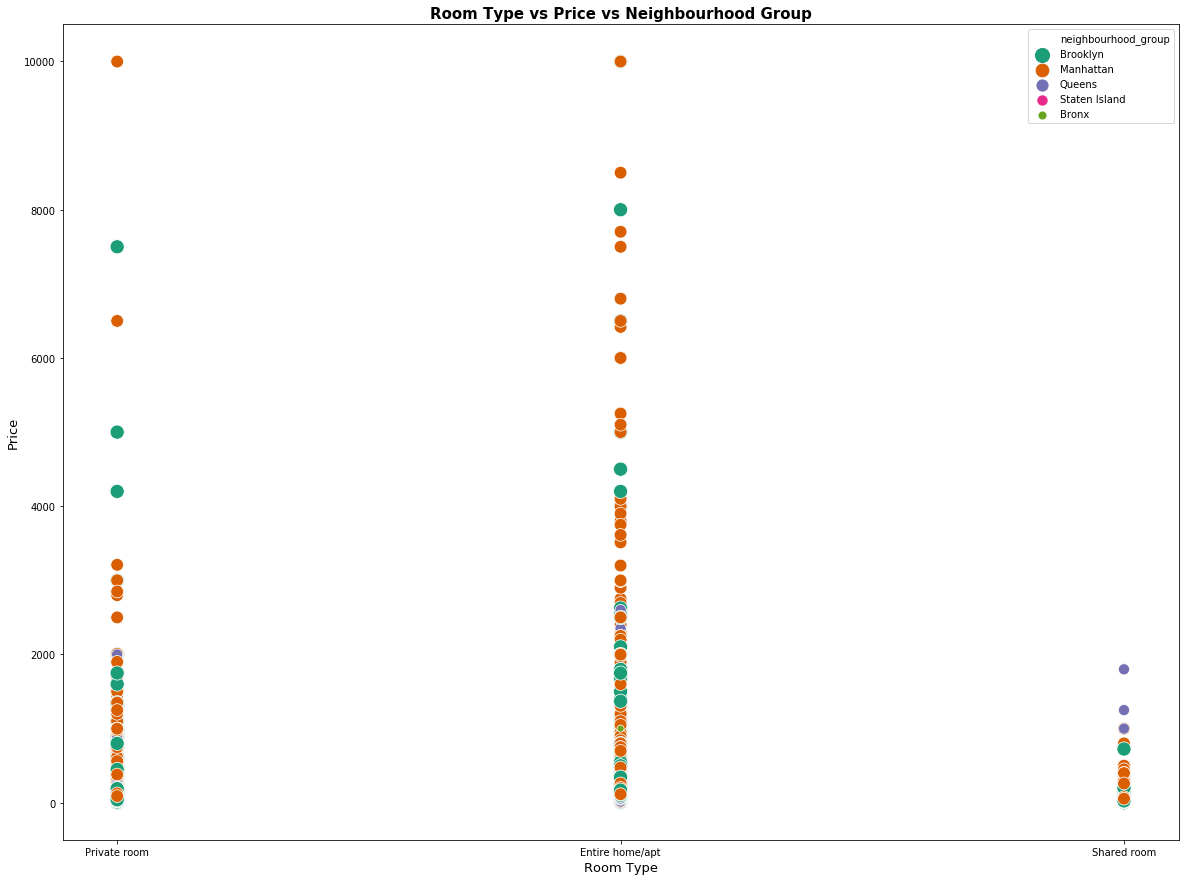

In [53]:
plt.figure(figsize=(20,15))
sns.scatterplot(x="room_type", y="price",
            hue="neighbourhood_group", size="neighbourhood_group",
            sizes=(50, 200), palette="Dark2", data=nyc_data)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price vs Neighbourhood Group",size=15, weight='bold')

Another graph is about ``price`` vs ``number of reviews`` based on ``neighborhood group``. It shows us the lowest prices have higher reviews than the higher prices. It shows negative correlation between ``price`` and ``number of reviews``. Also ``Manhattan``, ``Brooklyn`` and ``Queens`` areas have higher reviews than others.

Text(0.5, 1.0, 'Price vs Number of Reviews vs Neighbourhood Group')

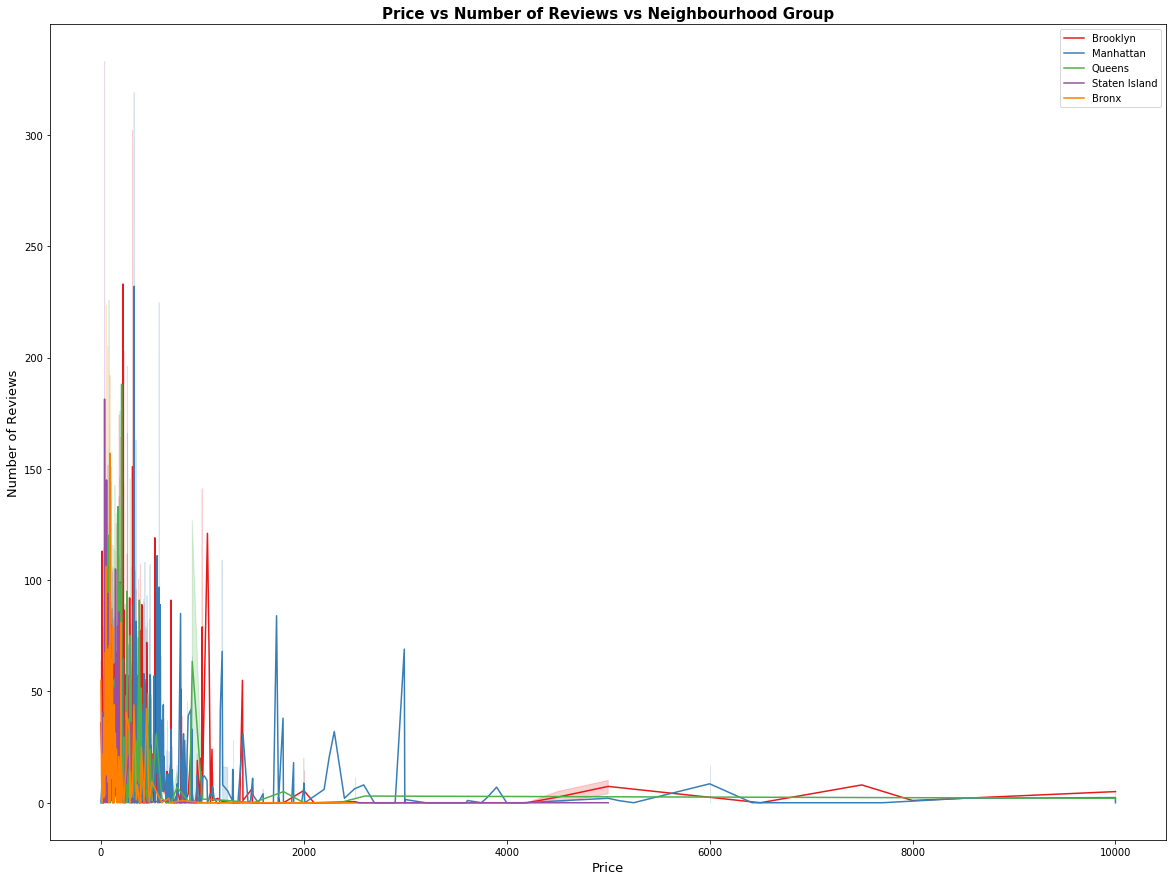

In [54]:
plt.figure(figsize=(20,15))
sns.set_palette("Set1")

sns.lineplot(x='price', y='number_of_reviews', 
             data=nyc_data[nyc_data['neighbourhood_group']=='Brooklyn'],
             label='Brooklyn')
sns.lineplot(x='price', y='number_of_reviews', 
             data=nyc_data[nyc_data['neighbourhood_group']=='Manhattan'],
             label='Manhattan')
sns.lineplot(x='price', y='number_of_reviews', 
             data=nyc_data[nyc_data['neighbourhood_group']=='Queens'],
             label='Queens')
sns.lineplot(x='price', y='number_of_reviews', 
             data=nyc_data[nyc_data['neighbourhood_group']=='Staten Island'],
             label='Staten Island')
sns.lineplot(x='price', y='number_of_reviews', 
             data=nyc_data[nyc_data['neighbourhood_group']=='Bronx'],
             label='Bronx')
plt.xlabel("Price", size=13)
plt.ylabel("Number of Reviews", size=13)
plt.title("Price vs Number of Reviews vs Neighbourhood Group",size=15, weight='bold')

Before examining ``price`` feature, categorical variables will be mapped with help of ``cat.code``. This will assist to make easier and comprehensible data analysis. 

In [55]:
nyc_data['neighbourhood_group']= nyc_data['neighbourhood_group'].astype("category").cat.codes
nyc_data['neighbourhood'] = nyc_data['neighbourhood'].astype("category").cat.codes
nyc_data['room_type'] = nyc_data['room_type'].astype("category").cat.codes
nyc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null int8
neighbourhood                     48895 non-null int16
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null int8
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64
dtyp

Text(0.5, 1.0, 'Price Distribution Plot')

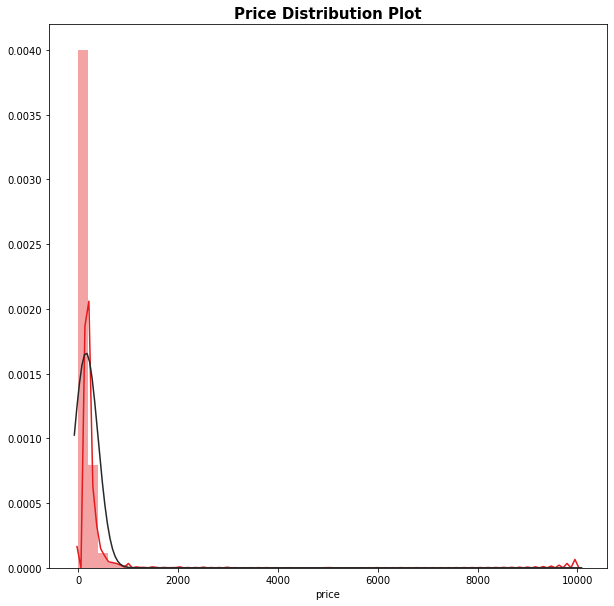

In [56]:
plt.figure(figsize=(10,10))
sns.distplot(nyc_data['price'], fit=norm)
plt.title("Price Distribution Plot",size=15, weight='bold')

The above distribution graph shows that there is a right-skewed distribution on ``price``. This means there is a positive skewness. Log transformation will be used to make this feature less skewed. This will help to make easier interpretation and better statistical analysis

Since division by zero is a problem, ``log+1`` transformation would be better.

In [57]:
nyc_data['price_log'] = np.log(nyc_data.price+1)

With help of log transformation, now, price feature have normal distribution. 

Text(0.5, 1.0, 'Log-Price Distribution Plot')

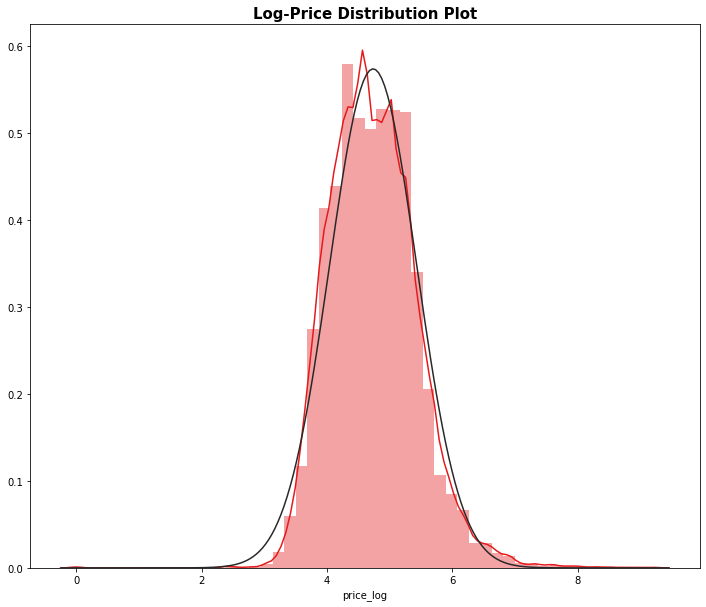

In [58]:
plt.figure(figsize=(12,10))
sns.distplot(nyc_data['price_log'], fit=norm)
plt.title("Log-Price Distribution Plot",size=15, weight='bold')

In below graph, the good fit indicates that normality is a reasonable approximation.

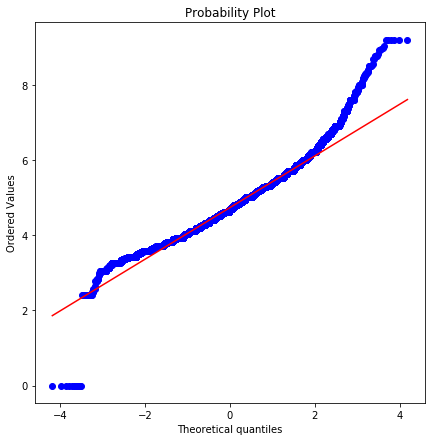

In [59]:
plt.figure(figsize=(7,7))
stats.probplot(nyc_data['price_log'], plot=plt)
plt.show()

Now it is time to prepare data for modeling. First, non-nominal data and old ``price`` feature will be eliminated.

In [60]:
nyc_model = nyc_data.drop(columns=['name','id' ,'host_id','host_name', 
                                   'last_review','price'])
nyc_model.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
price_log                             0
dtype: int64

``Number of reviews`` feature has some missing data. For this feature, missing data will be replaced with mean. Since the data is more symmetric, mean replacement would be better. 

In [61]:
mean = nyc_model['reviews_per_month'].mean()
nyc_model['reviews_per_month'].fillna(mean, inplace=True)
nyc_model.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
price_log                         0
dtype: int64

Now it is time to make more details about data. A correlation table will be created and the Pearson method will be used.

Text(0.5, 1, 'Correlation Matrix')

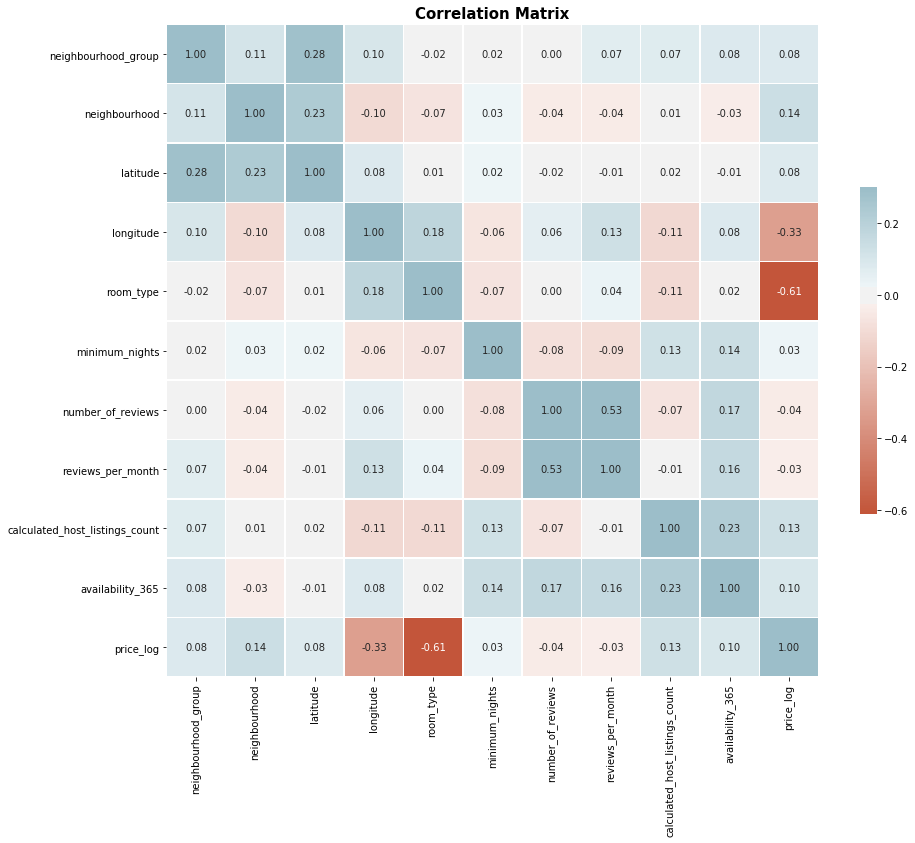

In [62]:
plt.figure(figsize=(15,12))
palette = sns.diverging_palette(20, 220, n=256)
corr=nyc_model.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(11, 0))
plt.title("Correlation Matrix",size=15, weight='bold')

The correlation table shows that there is no strong relationship between price and other features. This indicates no feature needed to be taken out of data. This relationship will be detailed with Residual Plots and Multicollinearity.

## Residual Plots

Residual Plot is strong method to detect outliers, non-linear data and detecting data for regression models. The below charts show the residual plots for each feature with the ``price``. 

An ideal Residual Plot, the red line would be horizontal. Based on the below charts, most features are non-linear. On the other hand, there are not many outliers in each feature. This result led to underfitting. Underfitting can occur when input features do not have a strong relationship to target variables or over-regularized. For avoiding underfitting new data features can be added or regularization weight could be reduced.

In this repository, since the input feature data could not be increased, Regularized Linear Models will be used for regularization and polynomial transformation will be made to avoid underfitting. 

In [63]:
nyc_model_x, nyc_model_y = nyc_model.iloc[:,:-1], nyc_model.iloc[:,-1]

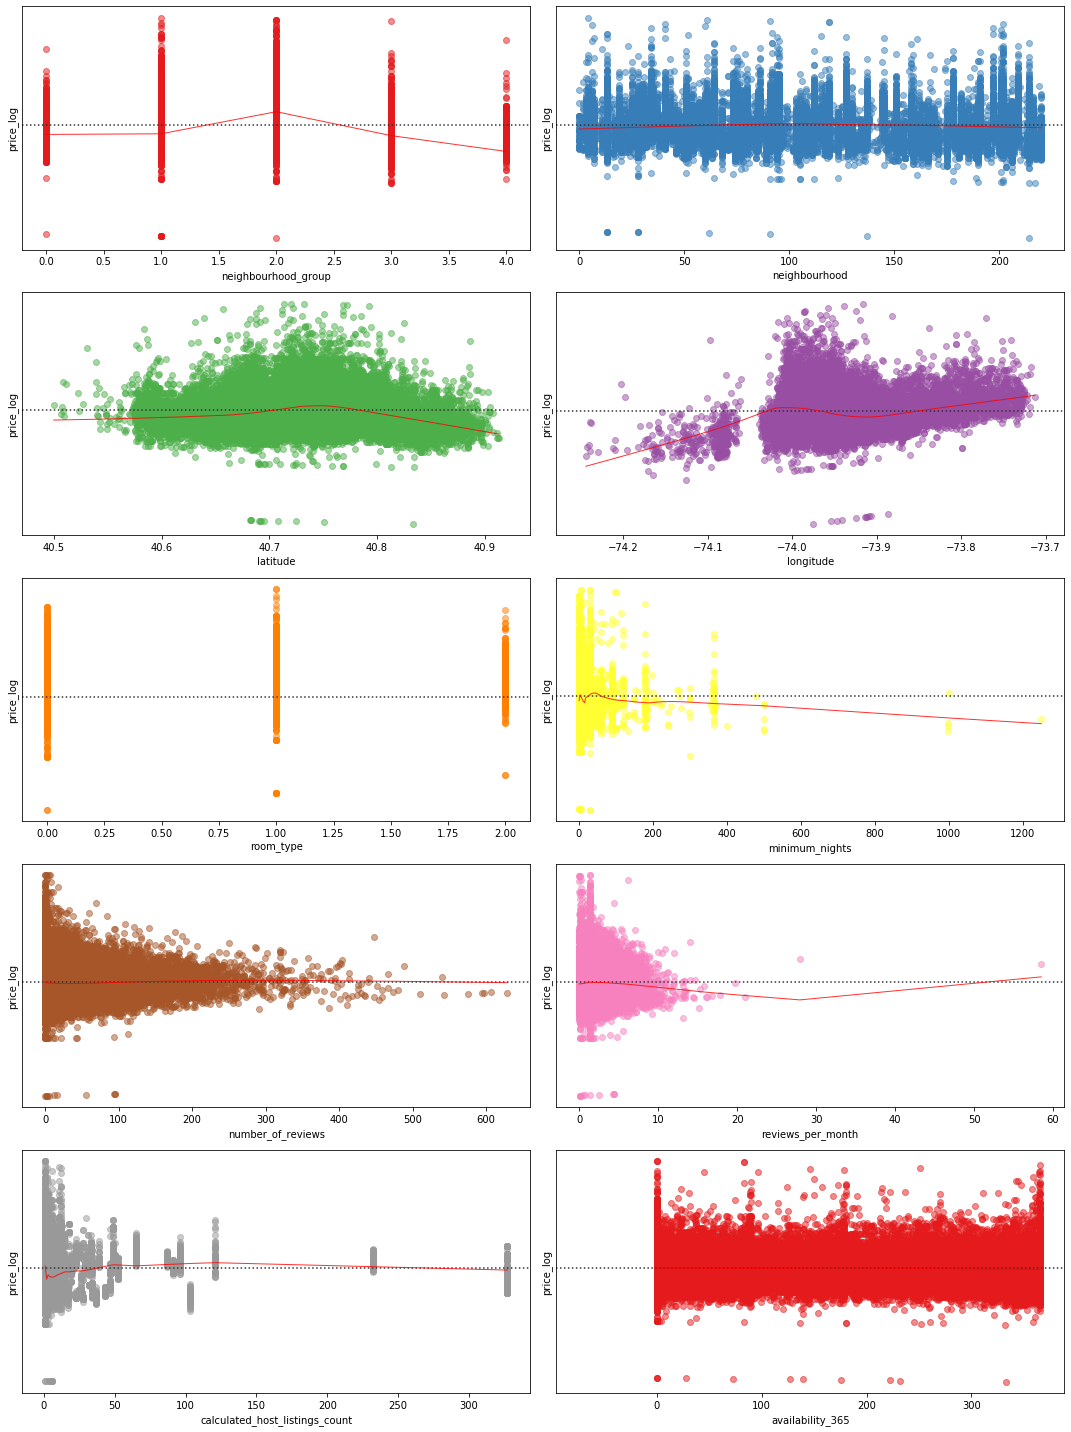

In [64]:
f, axes = plt.subplots(5, 2, figsize=(15, 20))
sns.residplot(nyc_model_x.iloc[:,0],nyc_model_y, lowess=True, ax=axes[0, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(nyc_model_x.iloc[:,1],nyc_model_y, lowess=True, ax=axes[0, 1],
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(nyc_model_x.iloc[:,2],nyc_model_y, lowess=True, ax=axes[1, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(nyc_model_x.iloc[:,3],nyc_model_y, lowess=True, ax=axes[1, 1], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(nyc_model_x.iloc[:,4],nyc_model_y, lowess=True, ax=axes[2, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(nyc_model_x.iloc[:,5],nyc_model_y, lowess=True, ax=axes[2, 1], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(nyc_model_x.iloc[:,6],nyc_model_y, lowess=True, ax=axes[3, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(nyc_model_x.iloc[:,7],nyc_model_y, lowess=True, ax=axes[3, 1], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(nyc_model_x.iloc[:,8],nyc_model_y, lowess=True, ax=axes[4, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(nyc_model_x.iloc[:,9],nyc_model_y, lowess=True, ax=axes[4, 1], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.setp(axes, yticks=[])
plt.tight_layout()

## Multicollinearity

Multicollinearity will help to measure the relationship between explanatory variables in multiple regression. If there is multicollinearity occurs, these highly related input variables should be eliminated from the model.

In this repository, multicollinearity will be control with ``Eigen vector values`` results. 

In [65]:
#Eigen vector of a correlation matrix.
multicollinearity, V=np.linalg.eig(corr)
multicollinearity

array([1.94766095, 1.64337523, 1.41516454, 1.26383356, 0.32595472,
       0.46300457, 0.66853039, 0.70054096, 0.76213034, 0.93539909,
       0.87440567])

None one of the eigenvalues of the correlation matrix is close to zero. It means that there is no multicollinearity exists in the data.

## Feature Selection and GridSearch

First, ``Standard Scaler`` technique will be used to normalize the data set. Thus, each feature has 0 mean and 1 standard deviation. 

In [66]:
scaler = StandardScaler()
nyc_model_x = scaler.fit_transform(nyc_model_x)

Secondly, data will be split in a 70–30 ratio

In [67]:
X_train, X_test, y_train, y_test = train_test_split(nyc_model_x, nyc_model_y, test_size=0.3,random_state=42)

Now it is time to build a ``feature importance`` graph. For this ``Extra Trees Classifier`` method will be used. In the below code, ``lowess=True`` makes sure the lowest regression line is drawn.

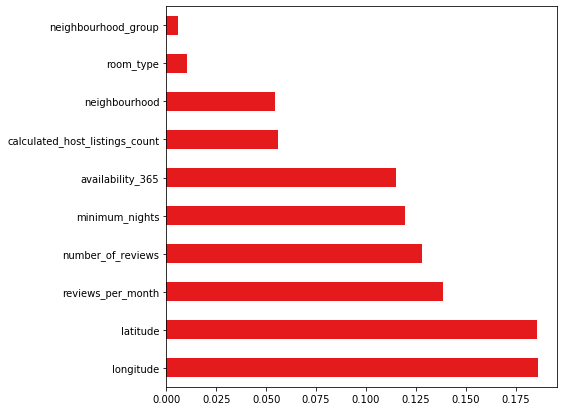

In [68]:
lab_enc = preprocessing.LabelEncoder()

feature_model = ExtraTreesClassifier(n_estimators=50)
feature_model.fit(X_train,lab_enc.fit_transform(y_train))

plt.figure(figsize=(7,7))
feat_importances = pd.Series(feature_model.feature_importances_, index=nyc_model.iloc[:,:-1].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

The above graph shows the feature importance of dataset. According to that, ``neighborhood group`` and ``room type`` have the lowest importance on the model. Under this result, the model building will be made in 2 phases. In the first phase, models will be built within all features and in the second phase, models will be built without ``neighborhood group`` and ``room type`` features.  

# 3. Model Building

## Phase 1 - With All Features

Correlation matrix, Residual Plots and Multicollinearity results show that underfitting occurs on the model and there is no multicollinearity on the independent variables. Avoiding underfitting will be made with ``Polynomial Transformation`` since no new features can not be added or replaced with the existing ones.  

In model building section, `Linear Regression`, `Ridge Regression`, `Lasso Regression`, and `ElasticNet Regression` models will be built. These models will be used to avoiding plain ``Linear Regression`` and show the results with a little of regularization. 

First, `GridSearchCV` algorithm will be used to find the best parameters and tuning hyperparameters for each model. In this algorithm ``5-Fold Cross Validation`` and ``Mean Squared Error Regression Loss`` metrics will be used. 

In [69]:
### Linear Regression ###

def linear_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_LR= LinearRegression()

    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_LR = GridSearchCV(estimator=model_LR,  
                         param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_LR.fit(input_x, input_y)
    best_parameters_LR = grid_search_LR.best_params_  
    best_score_LR = grid_search_LR.best_score_ 
    print(best_parameters_LR)
    print(best_score_LR)


# linear_reg(nyc_model_x, nyc_model_y)

In [70]:
### Ridge Regression ###

def ridge_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_Ridge= Ridge()

    # prepare a range of alpha values to test
    alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    normalizes= ([True,False])

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_Ridge = GridSearchCV(estimator=model_Ridge,  
                         param_grid=(dict(alpha=alphas, normalize= normalizes)),
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_Ridge.fit(input_x, input_y)
    best_parameters_Ridge = grid_search_Ridge.best_params_  
    best_score_Ridge = grid_search_Ridge.best_score_ 
    print(best_parameters_Ridge)
    print(best_score_Ridge)
    
# ridge_reg(nyc_model_x, nyc_model_y)

In [71]:
### Lasso Regression ###

def lasso_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_Lasso= Lasso()

    # prepare a range of alpha values to test
    alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    normalizes= ([True,False])

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_lasso = GridSearchCV(estimator=model_Lasso,  
                         param_grid=(dict(alpha=alphas, normalize= normalizes)),
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_lasso.fit(input_x, input_y)
    best_parameters_lasso = grid_search_lasso.best_params_  
    best_score_lasso = grid_search_lasso.best_score_ 
    print(best_parameters_lasso)
    print(best_score_lasso)

# lasso_reg(nyc_model_x, nyc_model_y)

In [72]:
### ElasticNet Regression ###

def elastic_reg(input_x, input_y,cv=5):
    ## Defining parameters
    model_grid_Elastic= ElasticNet()

    # prepare a range of alpha values to test
    alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    normalizes= ([True,False])

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_elastic = GridSearchCV(estimator=model_grid_Elastic,  
                         param_grid=(dict(alpha=alphas, normalize= normalizes)),
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_elastic.fit(input_x, input_y)
    best_parameters_elastic = grid_search_elastic.best_params_  
    best_score_elastic = grid_search_elastic.best_score_ 
    print(best_parameters_elastic)
    print(best_score_elastic)

# elastic_reg(nyc_model_x, nyc_model_y)

### K-Fold Cross Validation

Before model building, 5-Fold Cross Validation will be implemented for validation.

In [73]:
kfold_cv=KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in kfold_cv.split(nyc_model_x,nyc_model_y):
    X_train, X_test = nyc_model_x[train_index], nyc_model_x[test_index]
    y_train, y_test = nyc_model_y[train_index], nyc_model_y[test_index]

### Polynomial Transformation
The polynomial transformation will be made with a second degree which adding the square of each feature.

In [74]:
Poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train = Poly.fit_transform(X_train)
X_test = Poly.fit_transform(X_test)

### Model Prediction

In [75]:
##Linear Regression
lr = LinearRegression(copy_X= True, fit_intercept = True, normalize = True)
lr.fit(X_train, y_train)
lr_pred= lr.predict(X_test)

#Ridge Model
ridge_model = Ridge(alpha = 0.01, normalize = True)
ridge_model.fit(X_train, y_train)             
pred_ridge = ridge_model.predict(X_test) 

#Lasso Model
Lasso_model = Lasso(alpha = 0.001, normalize =False)
Lasso_model.fit(X_train, y_train)
pred_Lasso = Lasso_model.predict(X_test) 

#ElasticNet Model
model_enet = ElasticNet(alpha = 0.01, normalize=False)
model_enet.fit(X_train, y_train) 
pred_test_enet= model_enet.predict(X_test)


## Phase 2 - Without All Features

All steps from Phase 1, will be repeated in this Phase. The difference is, ``neighbourhood_group`` and ``room_type`` features will be eliminated.

In [76]:
nyc_model_xx= nyc_model.drop(columns=['neighbourhood_group', 'room_type'])

In [77]:
nyc_model_xx, nyc_model_yx = nyc_model_xx.iloc[:,:-1], nyc_model_xx.iloc[:,-1]
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(nyc_model_xx, nyc_model_yx, test_size=0.3,random_state=42)

In [78]:
scaler = StandardScaler()
nyc_model_xx = scaler.fit_transform(nyc_model_xx)

In [79]:
### Linear Regression ###
# linear_reg(nyc_model_xx, nyc_model_yx, cv=4)

In [80]:
### Ridge Regression ###
# ridge_reg(nyc_model_xx, nyc_model_yx, cv=4)

In [81]:
### Lasso Regression ###
# lasso_reg(nyc_model_xx, nyc_model_yx, cv=4)

In [82]:
### ElasticNet Regression ###
# elastic_reg(nyc_model_xx, nyc_model_yx, cv=4)

### K-Fold Cross Validation

In [83]:
kfold_cv=KFold(n_splits=4, random_state=42, shuffle=False)
for train_index, test_index in kfold_cv.split(nyc_model_xx,nyc_model_yx):
    X_train_x, X_test_x = nyc_model_xx[train_index], nyc_model_xx[test_index]
    y_train_x, y_test_x = nyc_model_yx[train_index], nyc_model_yx[test_index]

### Polynomial Transformation

In [84]:
Poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_x = Poly.fit_transform(X_train_x)
X_test_x = Poly.fit_transform(X_test_x)

### Model Prediction

In [85]:
###Linear Regression
lr_x = LinearRegression(copy_X= True, fit_intercept = True, normalize = True)
lr_x.fit(X_train_x, y_train_x)
lr_pred_x= lr_x.predict(X_test_x)

###Ridge
ridge_x = Ridge(alpha = 0.01, normalize = True)
ridge_x.fit(X_train_x, y_train_x)           
pred_ridge_x = ridge_x.predict(X_test_x) 

###Lasso
Lasso_x = Lasso(alpha = 0.001, normalize =False)
Lasso_x.fit(X_train_x, y_train_x)
pred_Lasso_x = Lasso_x.predict(X_test_x) 

##ElasticNet
model_enet_x = ElasticNet(alpha = 0.01, normalize=False)
model_enet_x.fit(X_train_x, y_train_x) 
pred_train_enet_x= model_enet_x.predict(X_train_x)
pred_test_enet_x= model_enet_x.predict(X_test_x)


# 4. Model Comparison

In this part, 3 metrics will be calculated for evaluating predictions.

* ``Mean Absolute Error (MAE)``    shows the difference between predictions and actual values.

* ``Root Mean Square Error (RMSE)`` shows how accurately the model predicts the response.

*                   ``R^2``  will be calculated to find the goodness of fit measure.

In [86]:
print('-------------Lineer Regression-----------')

print('--Phase-1--')
print('MAE: %f'% mean_absolute_error(y_test, lr_pred))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, lr_pred)))   
print('R2 %f' % r2_score(y_test, lr_pred))

print('--Phase-2--')
print('MAE: %f'% mean_absolute_error(y_test_x, lr_pred_x))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test_x, lr_pred_x)))   
print('R2 %f' % r2_score(y_test_x, lr_pred_x))

print('---------------Ridge ---------------------')

print('--Phase-1--')
print('MAE: %f'% mean_absolute_error(y_test, pred_ridge))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, pred_ridge)))   
print('R2 %f' % r2_score(y_test, pred_ridge))

print('--Phase-2--')
print('MAE: %f'% mean_absolute_error(y_test_x, pred_ridge_x))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test_x, pred_ridge_x)))   
print('R2 %f' % r2_score(y_test_x, pred_ridge_x))

print('---------------Lasso-----------------------')

print('--Phase-1--')
print('MAE: %f' % mean_absolute_error(y_test, pred_Lasso))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, pred_Lasso)))
print('R2 %f' % r2_score(y_test, pred_Lasso))

print('--Phase-2--')
print('MAE: %f' % mean_absolute_error(y_test_x, pred_Lasso_x))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test_x, pred_Lasso_x)))
print('R2 %f' % r2_score(y_test_x, pred_Lasso_x))

print('---------------ElasticNet-------------------')

print('--Phase-1 --')
print('MAE: %f' % mean_absolute_error(y_test,pred_test_enet)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_enet))) #RMSE
print('R2 %f' % r2_score(y_test, pred_test_enet))

print('--Phase-2--')
print('MAE: %f' % mean_absolute_error(y_test_x,pred_test_enet_x)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test_x,pred_test_enet_x))) #RMSE
print('R2 %f' % r2_score(y_test_x, pred_test_enet_x))

-------------Lineer Regression-----------
--Phase-1--
MAE: 0.377923
RMSE: 0.522021
R2 0.527663
--Phase-2--
MAE: 0.531963
RMSE: 0.685894
R2 0.184227
---------------Ridge ---------------------
--Phase-1--
MAE: 0.377915
RMSE: 0.522038
R2 0.527631
--Phase-2--
MAE: 0.529255
RMSE: 0.679340
R2 0.199742
---------------Lasso-----------------------
--Phase-1--
MAE: 0.375922
RMSE: 0.520400
R2 0.530591
--Phase-2--
MAE: 0.523562
RMSE: 0.671290
R2 0.218595
---------------ElasticNet-------------------
--Phase-1 --
MAE: 0.371707
RMSE: 0.518862
R2 0.533362
--Phase-2--
MAE: 0.524883
RMSE: 0.670878
R2 0.219553


The results show that all models have similar prediction results. Phase 1 and 2 have a great difference for each metric. All metric values are increased in Phase 2 it means, the prediction error value is higher in that Phase and model explainability are very low the variability of the response data around mean.

* The MAE value of 0 indicates no error on the model. In other words, there is a perfect prediction. The above results show that all predictions have great error especially in phase 2. 
* RMSE gives an idea of how much error the system typically makes in its predictions. The above results show that all models with each phase have significant errors.
* R2 represents the proportion of the variance for a dependent variable that's explained by an independent variable. The above results show that, in phase 1, 52% of data fit the regression model while in phase 2, 20% of data fit the regression model. 

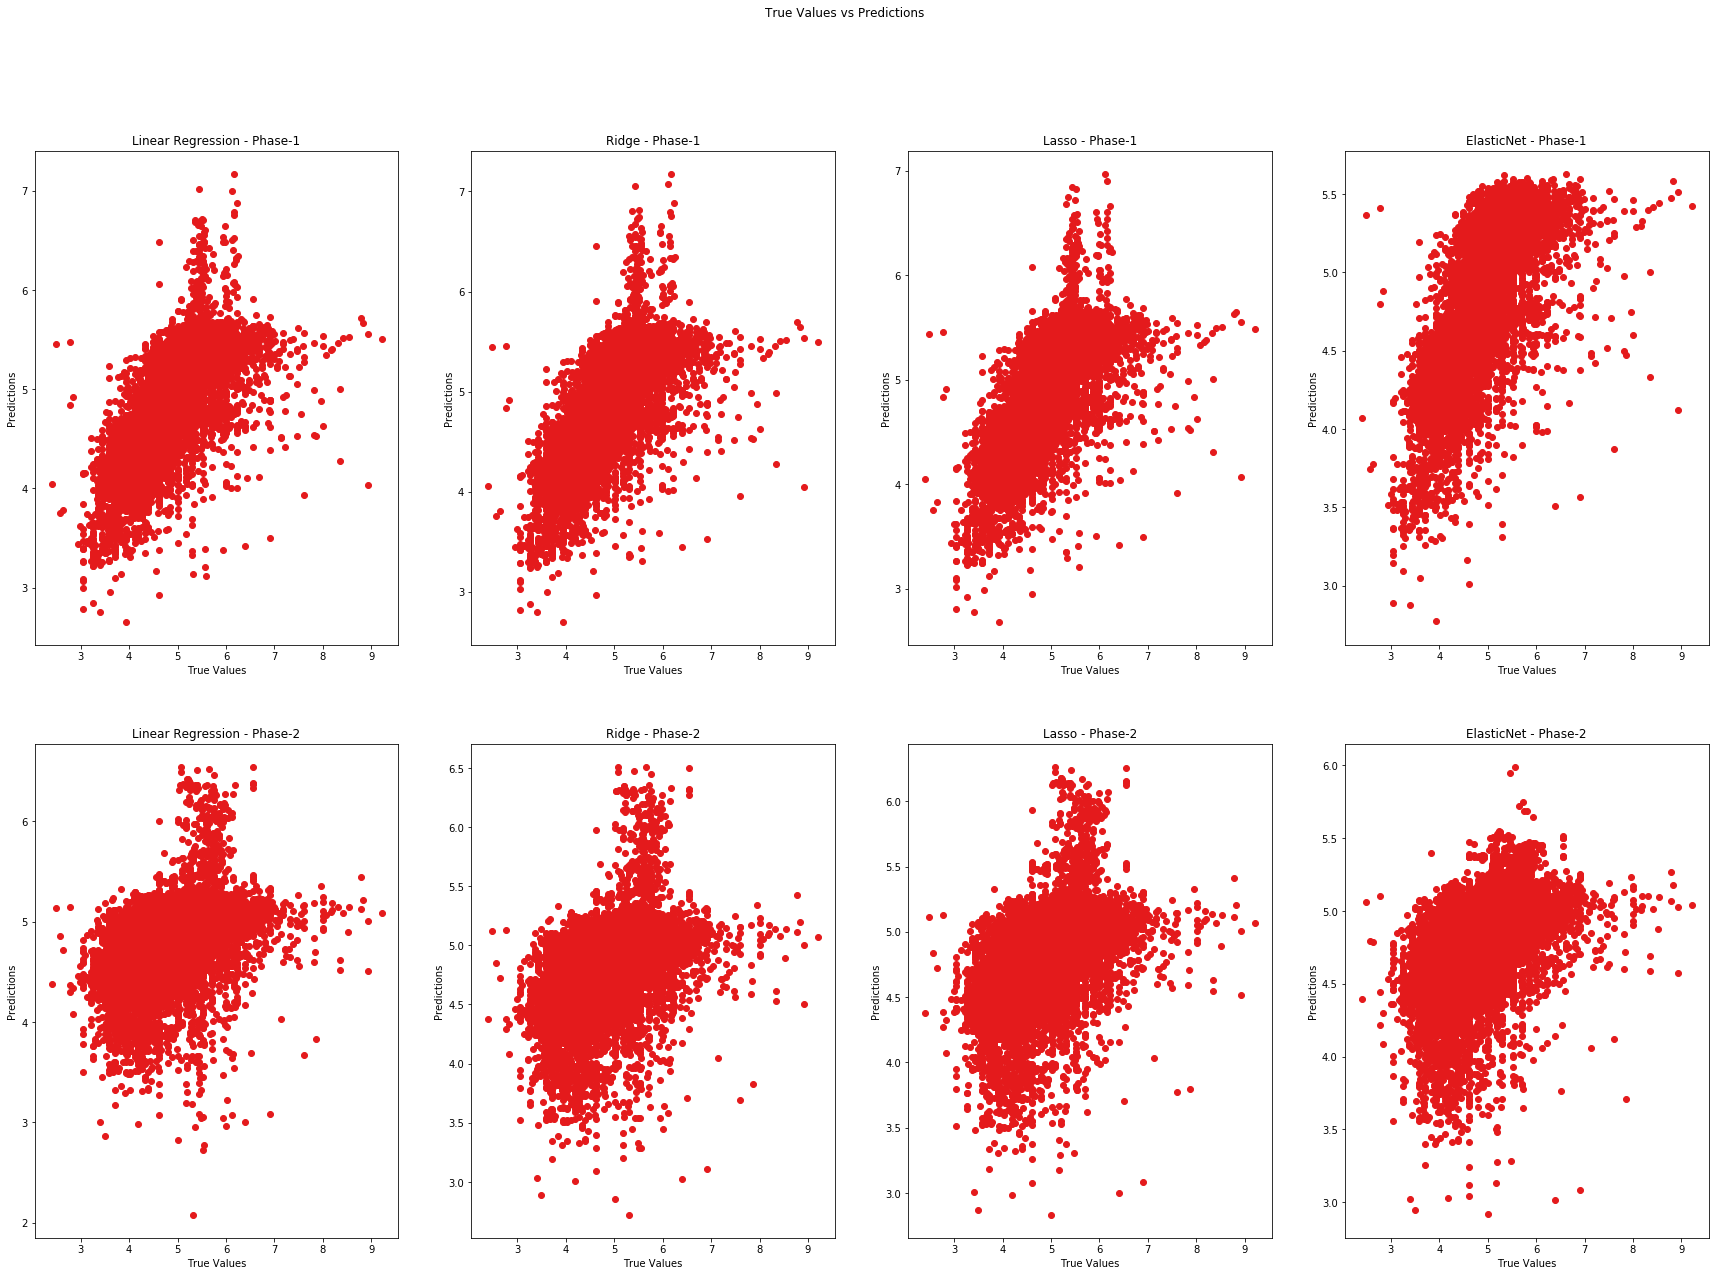

In [87]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(30, 20))
fig.suptitle('True Values vs Predictions')

ax1.scatter(y_test, lr_pred)
ax1.set_title('Linear Regression - Phase-1')

ax2.scatter(y_test, pred_ridge)
ax2.set_title('Ridge - Phase-1')

ax3.scatter(y_test, pred_Lasso)
ax3.set_title('Lasso - Phase-1')

ax4.scatter(y_test, pred_test_enet)
ax4.set_title('ElasticNet - Phase-1')

ax5.scatter(y_test_x, lr_pred_x)
ax5.set_title('Linear Regression - Phase-2')

ax6.scatter(y_test_x, pred_ridge_x)
ax6.set_title('Ridge - Phase-2')

ax7.scatter(y_test_x, pred_Lasso_x)
ax7.set_title('Lasso - Phase-2')

ax8.scatter(y_test_x, pred_test_enet_x)
ax8.set_title('ElasticNet - Phase-2')

for ax in fig.get_axes():
    ax.set(xlabel='True Values', ylabel='Predictions')


The last graph is about the difference between True Values vs Prediction for Phase 1 and Phase 2. The great difference between the two phases has been seen in 'Linear Regression' and 'ElasticNet Regression' models. 

# 5. Conclusion

In this repository, I try to make predictions with different Regression models and comparing the importance metric results. I hope it would help other people. 

Any comments and feedback are welcome.